In [1]:
# example output
import fsspec
import xarray as xr

zarr_data_path = 'gs://leap-persistent/jbusecke/ocean_emulators/OM4/OM4_raw_test.zarr'
nc_grid_path = 'gs://leap-persistent/sd5313/OM4-5daily/ocean_static_no_mask_table.nc'

ds_raw = xr.open_dataset(zarr_data_path, engine='zarr', chunks={})

with fsspec.open(nc_grid_path) as f:
    ds_grid = xr.open_dataset(f).load().drop_vars('time')
ds_grid = ds_grid.set_coords(ds_grid.data_vars)

# from https://github.com/m2lines/ocean_emulators/issues/17
dz = xr.DataArray(
    [
        5,
        10,
        15,
        20,
        30,
        50,
        70,
        100,
        150,
        200,
        250,
        300,
        400,
        500,
        600,
        800,
        1000,
        1000,
        1000,
    ],
    dims=["lev"],
)


ds = xr.merge([ds_raw, ds_grid]).assign_coords(dz=dz)
ds

<xarray.Dataset> Size: 2TB
Dimensions:       (lev: 19, nv: 2, time: 4745, xh: 1440, xq: 1441, yh: 1080,
                   yq: 1081)
Coordinates: (12/35)
  * lev           (lev) float64 152B 2.5 10.0 22.5 40.0 ... 4e+03 5e+03 6e+03
  * nv            (nv) float64 16B 1.0 2.0
  * time          (time) object 38kB 1958-01-03 12:00:00 ... 2022-12-29 12:00:00
  * xh            (xh) float64 12kB -299.7 -299.5 -299.2 ... 59.53 59.78 60.03
  * xq            (xq) float64 12kB -299.8 -299.6 -299.3 ... 59.66 59.91 60.16
  * yh            (yh) float64 9kB -80.39 -80.31 -80.23 ... 89.73 89.84 89.95
    ...            ...
    dyCv          (yq, xh) float32 6MB nan nan nan nan ... 246.8 148.7 49.76
    areacello_cu  (yh, xq) float32 6MB nan 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    areacello_cv  (yq, xh) float32 6MB nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    areacello_bu  (yq, xq) float32 6MB nan nan nan ... 1.203e+06 4.55e+05
    basin         (yh, xh) int32 6MB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz            (lev) int64 152B 5 10 15 20 30 50 ... 600 800 1000 1000 1000
Data variables:
    hfds          (time, yh, xh) float32 30GB dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    so            (time, lev, yh, xh) float32 561GB dask.array<chunksize=(1, 19, 1080, 1440), meta=np.ndarray>
    tauuo         (time, yh, xq) float32 30GB dask.array<chunksize=(1, 1080, 1441), meta=np.ndarray>
    tauvo         (time, yq, xh) float32 30GB dask.array<chunksize=(1, 1081, 1440), meta=np.ndarray>
    thetao        (time, lev, yh, xh) float32 561GB dask.array<chunksize=(1, 19, 1080, 1440), meta=np.ndarray>
    time_bnds     (time, nv) object 76kB dask.array<chunksize=(1500, 2), meta=np.ndarray>
    uo            (time, lev, yh, xq) float32 561GB dask.array<chunksize=(1, 19, 1080, 1441), meta=np.ndarray>
    vo            (time, lev, yq, xh) float32 561GB dask.array<chunksize=(1, 19, 1081, 1440), meta=np.ndarray>
    zos           (time, yh, xh) float32 30GB dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
Attributes:
    associated_files:  areacello: 19580101.ocean_static.nc
    grid_tile:         N/A
    grid_type:         regular
    title:             OM4p25_5daily_cycle1

In [2]:
#import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
from scipy import stats
from dask.diagnostics import ProgressBar

In [3]:
ds_raw

<xarray.Dataset> Size: 2TB
Dimensions:    (time: 4745, yh: 1080, xh: 1440, lev: 19, nv: 2, xq: 1441,
                yq: 1081)
Coordinates:
  * lev        (lev) float64 152B 2.5 10.0 22.5 40.0 ... 4e+03 5e+03 6e+03
  * nv         (nv) float64 16B 1.0 2.0
  * time       (time) object 38kB 1958-01-03 12:00:00 ... 2022-12-29 12:00:00
  * xh         (xh) float64 12kB -299.7 -299.5 -299.2 ... 59.53 59.78 60.03
  * xq         (xq) float64 12kB -299.8 -299.6 -299.3 ... 59.66 59.91 60.16
  * yh         (yh) float64 9kB -80.39 -80.31 -80.23 ... 89.73 89.84 89.95
  * yq         (yq) float64 9kB -80.43 -80.35 -80.27 -80.19 ... 89.78 89.89 90.0
Data variables:
    hfds       (time, yh, xh) float32 30GB dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    so         (time, lev, yh, xh) float32 561GB dask.array<chunksize=(1, 19, 1080, 1440), meta=np.ndarray>
    tauuo      (time, yh, xq) float32 30GB dask.array<chunksize=(1, 1080, 1441), meta=np.ndarray>
    tauvo      (time, yq, xh) float32 30GB dask.array<chunksize=(1, 1081, 1440), meta=np.ndarray>
    thetao     (time, lev, yh, xh) float32 561GB dask.array<chunksize=(1, 19, 1080, 1440), meta=np.ndarray>
    time_bnds  (time, nv) object 76kB dask.array<chunksize=(1500, 2), meta=np.ndarray>
    uo         (time, lev, yh, xq) float32 561GB dask.array<chunksize=(1, 19, 1080, 1441), meta=np.ndarray>
    vo         (time, lev, yq, xh) float32 561GB dask.array<chunksize=(1, 19, 1081, 1440), meta=np.ndarray>
    zos        (time, yh, xh) float32 30GB dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
Attributes:
    associated_files:  areacello: 19580101.ocean_static.nc
    grid_tile:         N/A
    grid_type:         regular
    title:             OM4p25_5daily_cycle1

In [4]:
def global_average(ds: xr.Dataset, variable: str) -> xr.DataArray:
    yh = ds['yh']
    cos_lat_weights = np.cos(np.deg2rad(yh))

    # Normalize the weights by their sum so they sum to 1
    cos_lat_weights /= cos_lat_weights.sum()

    # Perform the weighted average across the latitude and longitude dimensions
    weighted_mean = (ds[variable] * cos_lat_weights).mean(dim=['yh', 'xh'], keep_attrs=True)

    return weighted_mean

In [13]:
def plot_hovmoller_global_mean_temperature(da: xr.DataArray, ax=None) -> plt.Axes:
    """
    Plots a Hovmöller diagram of the global mean temperature over time and depth.

    Parameters:
    - da: xarray.DataArray with dimensions (time, depth) containing the data to plot.
    - ax: Optional; an existing matplotlib axis to plot on. If None, creates a new axis.

    Returns:
    - ax: The matplotlib axis with the plot.
    """
    if ax is None:
        ax = plt.gca()

    # Loading the data into memory
    with ProgressBar():
        print("Loading Plot Data")
        da = da.load()

    # Plotting the Hovmöller diagram without the automatic colorbar
    hovmoller = da.plot.contourf(
        ax=ax,
        x='time',
        y='lev',
        levels=20,
        cmap='RdBu_r',
        extend='both',
        add_colorbar=False  # Prevents automatic colorbar
    )
    ax.invert_yaxis()
    ax.set_ylabel('Depth')
    ax.set_title('Global Mean Temperature Hovmöller Diagram')

    # Use a default label if 'units' is not present
    units = da.attrs.get('units', '')
    plt.colorbar(hovmoller, ax=ax, label=f'{da.name} ({units})')

    return ax

In [19]:
def plot_hovmoller_global_mean_temperature_ds(ds: xr.Dataset, variable: str, ax=None) -> plt.Axes:
    """
    Plots a Hovmöller diagram of the global mean temperature over time and depth.

    Parameters:
    - da: xarray.DataArray with dimensions (time, depth) containing the data to plot.
    - ax: Optional; an existing matplotlib axis to plot on. If None, creates a new axis.

    Returns:
    - ax: The matplotlib axis with the plot.
    """
    da = global_average(ds, variable)
    da = da - da.mean(dim='time')
    
    if ax is None:
        ax = plt.gca()

    # Loading the data into memory
    with ProgressBar():
        print("Loading Plot Data")
        da = da.load()

    # Plotting the Hovmöller diagram without the automatic colorbar
    hovmoller = da.plot.contourf(
        ax=ax,
        x='time',
        y='lev',
        levels=20,
        cmap='RdBu_r',
        extend='both',
        add_colorbar=False  # Prevents automatic colorbar
    )
    ax.invert_yaxis()
    ax.set_ylabel('Depth')
    ax.set_title('Global Mean Temperature Hovmöller Diagram')

    # Use a default label if 'units' is not present
    units = da.attrs.get('units', '')
    plt.colorbar(hovmoller, ax=ax, label=f'{da.name} ({units})')

    return ax

In [6]:
thetao_gm = global_average(ds, variable='thetao')

In [7]:
thetao_gm

<xarray.DataArray (time: 4745, lev: 19)> Size: 721kB
dask.array<mean_agg-aggregate, shape=(4745, 19), dtype=float64, chunksize=(1, 19), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 152B 2.5 10.0 22.5 40.0 ... 3.1e+03 4e+03 5e+03 6e+03
  * time     (time) object 38kB 1958-01-03 12:00:00 ... 2022-12-29 12:00:00
    dz       (lev) int64 152B 5 10 15 20 30 50 70 ... 500 600 800 1000 1000 1000

In [8]:
thetao_gm_anomalies = thetao_gm - thetao_gm.mean(dim='time')

In [9]:
thetao_gm_anomalies

<xarray.DataArray (time: 4745, lev: 19)> Size: 721kB
dask.array<sub, shape=(4745, 19), dtype=float64, chunksize=(1, 19), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 152B 2.5 10.0 22.5 40.0 ... 3.1e+03 4e+03 5e+03 6e+03
  * time     (time) object 38kB 1958-01-03 12:00:00 ... 2022-12-29 12:00:00
    dz       (lev) int64 152B 5 10 15 20 30 50 70 ... 500 600 800 1000 1000 1000

<Axes: title={'center': 'Global Mean Temperature Hovmöller Diagram'}, xlabel='time', ylabel='Depth'>

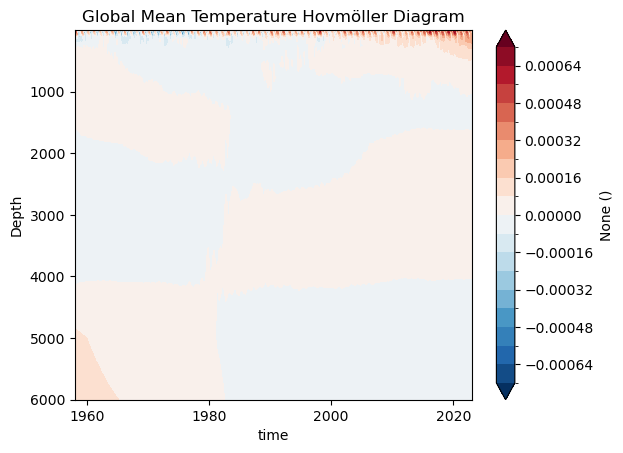

In [18]:
plot_hovmoller_global_mean_temperature(thetao_gm_anomalies) # this step is very slow

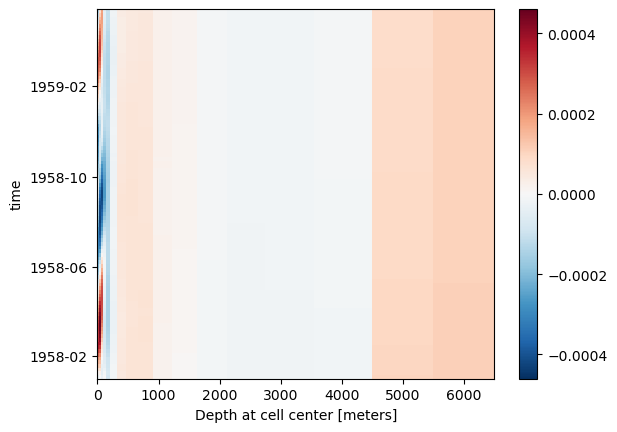

In [17]:
thetao_gm_anomalies[0:100,:].plot()